In [1]:
import sys
sys.path.append('/cluster/sj1/bb_opt/src')
sys.path.append('/cluster/sj1/bb_opt/scripts')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collect_stats as cs

%matplotlib inline

In [3]:
import collect_stats as cs


In [4]:
import test_fns

In [5]:
arrs = {}

In [345]:
exp_folder = '/cluster/sj1/bb_opt/experiments'
test_filepath = '/cluster/sj1/bb_opt/data/tatsu_pbm/test_files'
filedir = '/cluster/sj1/bb_opt/data/paper_data2'
num_tfs_to_test = 38
batches = [10, 20, 100, 200]
batches = [10]
#batches = [4]
num_acks = 100

In [7]:
def sigmoid(x, exp=np.exp):
  return 1.0 / (1.0 + exp(-x))

In [318]:
filenames = [
    #'hartmann6d',
    #'branin',
    #'bohachevsky',
    'ackley',
]
bb_fn = {filenames[i] : getattr(test_fns, filenames[i])() for i in range(len(filenames))}

In [350]:
to_read = {
    'ensemble13/o_pdts_grad_': [None, 'pdts'],
    #'ensemble13/o_er_grad_': [None, 'er'],
    #'ensemble13/o_ucb_grad_': [None, 'er'],
    #'ensemble13/o_pdts_rand_grad_randdiv_1_': [None, 'pdts_rand_div_1'],
    #'ensemble13/o_pdts_rand_grad_randdiv_2_': [None, 'pdts_rand_div_2'],
    'ensemble13/o_pdts_info_grad_': [None, 'pdts_info'],
    #'ensemble13/o_er_rand_grad_randdiv_1_': [None, 'er_rand_div_1'],
    #'ensemble13/o_er_info_grad_': [None, 'er_info'],
}

In [356]:
for k in to_read:
    arrs[k] = to_read[k]
for experiment in to_read:
    print('reading', experiment)
    arrs[experiment][0] = cs.get_data(exp_folder, experiment, batches, num_samples=20, mode="bayes_opt", filenames_to_extract=filenames)
    #cs.get_data(exp_folder, experiment, batches, num_samples=20, mode="bayes_opt")

reading ensemble13/o_pdts_grad_
reading sample 1
reading sample 2
reading sample 3
reading sample 4
reading sample 5
reading sample 6
reading sample 7
reading sample 8
reading sample 9
reading sample 10
reading sample 11
reading sample 12
reading sample 13
reading sample 14
reading sample 15
reading sample 16
reading sample 17
reading sample 18
reading sample 19
reading sample 20
reading ensemble13/o_pdts_info_grad_
reading sample 1
reading sample 2
reading sample 3
reading sample 4
reading sample 5
reading sample 6
reading sample 7
reading sample 8
reading sample 9
reading sample 10
reading sample 11
reading sample 12
reading sample 13
reading sample 14
reading sample 15
reading sample 16
reading sample 17
reading sample 18
reading sample 19
reading sample 20


In [11]:
to_eval = [
    'ensemble13/o_pdts_grad_',
    #'ensemble13/o_pdts_rand_grad_randdiv_1_',
    #'ensemble13/o_pdts_rand_grad_randdiv_2_',
    #'ensemble13/o_pdts_info_grad_',
]

In [13]:
idx_data_extractor = lambda x, filename : x['idx_frac'][0].item()

In [14]:
ack_rel_opt_val_data_extractor = lambda x, filename : x['ack_rel_opt_value']

In [15]:
ir_rel_opt_val_data_extractor = lambda x, filename : x['ir_rel_opt_value']

In [16]:
train_rmse_fn = lambda x, filename : x['logging'][1]['train']['std']

In [358]:
cs.prop_test(10, 
             filenames, 
             #ack_regret_fn, 
             ack_rel_opt_val_data_extractor,
             arrs,
             [to_eval[0], to_eval[1]],
             99,
             pval_threshold=1, 
             paired_test=False,
            )

comparing pdts pdts_info
ackley 0.38848819735541484 2.7145915627843733 2.7499978411736787 1 	 (std: 0.12846 0.12163, #n: 20 20)
combined pval: nan vs 0.38849
count: 1/1


In [42]:
cs.prop_test(40, 
             filenames, 
             ir_regret_fn, 
             arrs, 
             [to_eval[-2], to_eval[-1]],
             14,
             pval_threshold=1,
             paired_test=True,
            )

NameError: name 'ir_regret_fn' is not defined

In [46]:
import collect_stats as cs

In [55]:
cs.uniform_baseline_bb_fn(
    2,
    bb_fn,
    4,
    filenames, 
    ack_rel_opt_val_data_extractor,
    arrs,
    to_eval[0], 
    99,
    pval_threshold=1, 
)

comparing pdts
branin 5.237370760960503e-24 24.161627 1.813373504192776 0 	 (std: 1.12536 2.15831, #n: 18 18)
combined pval: 0.00000 vs nan
count: 0/1


In [311]:
filenames = [
    #'hartmann6d',
    #'branin',
    #'bohachevsky',
    'ackley',
]
bb_fn = {filenames[i] : getattr(test_fns, filenames[i])() for i in range(len(filenames))}

In [331]:
to_eval = [
    'ensemble13/o_pdts_grad_',
    #'ensemble13/o_ucb_grad_',
    #'ensemble13/o_pdts_rand_grad_randdiv_1_',
    #'ensemble13/o_pdts_rand_grad_randdiv_2_',
    'ensemble13/o_pdts_info_grad_',
    #'ensemble13/o_er_rand_grad_randdiv_1_',
    #'ensemble13/o_er_info_grad_',
]

In [152]:
ack_iter = 29
for batch_size in [20]:
    print("BATCH SIZE", batch_size)
    for filename in filenames:
        filename_printed = False
        for experiment in to_eval:
            if len(arrs[experiment][0]) == 0:
                continue
            idx_frac = None
            num_used = 0
            val_nll = 0
            try:
                for stats in arrs[experiment][0]:
                    if filename not in stats:
                        continue
                    if batch_size not in stats[filename]:
                        continue
                    if len(stats[filename][batch_size]) <= ack_iter:
                        continue
                    num_used += 1
                    mean = 0
                    #for i in range(len(stats[filename][batch_size])):
                        #mean += stats[filename][batch_size][i]['logging'][1]['best']['nll']
                    if len(stats[filename][batch_size]) > 0:
                        mean /= (len(stats[filename][batch_size]))
                    #val_nll += stats[filename][batch_size][0]['logging'][1]['best']['nll']
                    val_nll += mean
                    if idx_frac is None:
                        idx_frac = stats[filename][batch_size][ack_iter]['idx_frac']
                        #idx_frac = tf_labels[filename][stats[filename][batch_size][ack_iter]['ir_batch_cur_idx'][-1]]
                        #idx_frac = stats[filename][batch_size][ack_iter]['corr_stats'][1]
                    else:
                        idx_frac = idx_frac + stats[filename][batch_size][ack_iter]['idx_frac']
                        #idx_frac = torch.max(idx_frac, stats[filename][batch_size][ack_iter]['idx_frac'])
                        #idx_frac = idx_frac + tf_labels[filename][stats[filename][batch_size][ack_iter]['ir_batch_cur_idx'][-1]]
                        #idx_frac = idx_frac + stats[filename][batch_size][ack_iter]['corr_stats'][1]
                if num_used > 0:
                    if not filename_printed:
                        print(filename)
                        filename_printed = True
                    idx_frac = idx_frac/num_used
                    #idx_frac = idx_frac.numpy()
                    print(arrs[experiment][1] + ":", " ".join(("{:6.6f}".format(k) for k in idx_frac)), ";", "{:6.2f}".format(val_nll/num_used), "val_nll ;", str(num_used), "samples")
                    #print(arrs[experiment][1] + ":", str(idx_frac), ";", "{:6.2f}".format(val_nll/num_used), "val_nll ;", str(num_used), "samples")
            except Exception as e:
                pass

BATCH SIZE 20
chemvae
e13_it20: 0.068394 0.027590 0.016963 0.009838 ;   0.00 val_nll ; 40 samples
pdts_it20: 0.055785 0.024354 0.015531 0.009347 ;   0.00 val_nll ; 39 samples
mves_bs_0_it20: 0.063887 0.025413 0.015743 0.009276 ;   0.00 val_nll ; 60 samples
mves_div_10_bs_0_it20: 0.061247 0.025353 0.015786 0.009309 ;   0.00 val_nll ; 40 samples
mves_bs_0_it20_fp: 0.050060 0.022436 0.014587 0.008910 ;   0.00 val_nll ; 40 samples


In [179]:
import collect_stats as cs

In [37]:
ack_rel_opt_val_data_extractor = lambda x, filename : np.log(x['ack_rel_opt_value'])

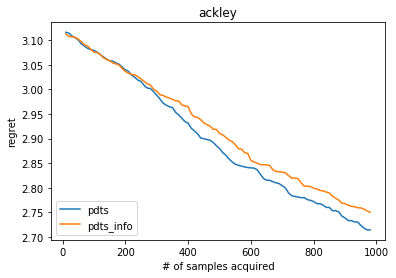

In [359]:
cs.plot_data_vs_ack_iter(
    10,
    filenames,
    'avg_seeds',
    'regret',
    #ack_regret_fn,
    ack_rel_opt_val_data_extractor,
    99,
    arrs,
    to_eval,
    legend_loc=3,
    figsize=(6, 4),
    num_samples_label=True,
    save_path='/cluster/sj1/bb_opt/plots',
    start_iter=0,
)

In [ ]:
cs.plot_data_vs_ack_iter(
    10,
    filenames[0:15],
    'avg_seeds',
    'gamma',
    lambda x : x['best_gamma'] if x['best_gamma'] is not None else 0,
    30,
    arrs,
    to_eval,
    legend_loc=3,
)